In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Import modules
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
import os
print(f'current working directory: {os.getcwd()}')

### Data Description
#### train_data:
backgrounds_1: \
backgrounds_2: \
chinese_neg: \
chinese_pos: \
english_neg: \
english_pos: \
logo_col_cn: \
logo_grey_en: \
logo_grey_ru: 

In [ ]:
#生成图片时，需要注意，红色覆盖黑色/黑色覆盖红色，随机，或者重合

In [ ]:
from PIL import Image
from utils.image_processing import ImageGenerator
import numpy as np
img = ImageGenerator('/data/Hangyu_Folder/OCR_Project/data/text.bmp')
text_background = img.image
#logo_ = np.array(img.scale_image('logo_1.png', 0.2, (300,500)))

# result = Image.fromarray(w.astype(np.uint8))
# result.save('out.bmp')

In [ ]:
out = im.transpose(PIL.Image.FLIP_LEFT_RIGHT)


In [ ]:
np.flip(text_background, (0, 1))

In [ ]:
flip(text_background)

In [ ]:
from utils.image_manipulation import rotate

In [ ]:
from utils.image_manipulation import flip

In [ ]:
img = ImageGenerator('/data/Hangyu_Folder/OCR_Project/data/logo_1.png')
text_background = img.image

In [ ]:
if __name__ == "__main__":
    a,b,c = demo()
from matplotlib import pyplot
from PIL import Image
result = Image.fromarray(c.astype(np.uint8))
result

In [ ]:
result = Image.fromarray(np.flip(text_background, (0, 1)).astype(np.uint8))
result

In [ ]:
text_background.shape

In [ ]:
test = []
for i in range(1126):
    for j in range(794):
        a = text_background[i,j,:]
        if np.logical_and(a > b, a < c).all():
            test.append(np.array([0,0,0]))
        else:
            test.append(a)

In [ ]:
#########在这里生成训练集和测试集
#x y 

In [ ]:
plt.imshow(np.array(test).reshape(1126,794,3))
plt.axis('off')
ttt = np.array(test).reshape(1126,794,3)
result = Image.fromarray(ttt.astype(np.uint8))

result.save('test.bmp')

In [ ]:
b = np.array([0,0,0])
c = np.array([200,200,200])
d = np.array([254,254,254])

In [ ]:
2682132  / 1126 /794

In [ ]:
t = ((np.array(test).reshape(1126,794,3) + logo_)/2).astype(np.uint8)

In [ ]:
test = []
for i in range(1126):
    for j in range(794):
        a = t[i,j,:]
        if np.logical_and(a > b, a < c).all():
            test.append(np.array([0,0,0]))
        else:
            test.append(a)


In [ ]:
result = Image.fromarray(((np.array(test).reshape(1126,794,3) + logo_)/2).astype(np.uint8))
result

In [ ]:
a = np.array([12,23,23])
b = np.array([11,25,22])
c = np.array([13,25,25])

In [ ]:
np.array([12,23,23]) < np.array([12,24,23]) & 

In [ ]:
from scipy import ndimage, misc


In [ ]:
text_background.shape

In [ ]:
%%time
 
full_img_45_1 = ndimage.rotate(text_background, 45, reshape=True)

In [ ]:
%%time

full_img_45_2 = rotate_image(text_background, 45)

In [ ]:
import cv2

result = Image.fromarray(rotate_image(text_background, 45).astype(np.uint8))
result

In [ ]:
img.shape

In [ ]:
import cv2

result = Image.fromarray(c.astype(np.uint8))
result

In [ ]:
image = cv2.imread("/data/Hangyu_Folder/OCR_Project/data/text.bmp")
angle = 45

In [3]:
from utils.image_manipulation import rotate, flip
from PIL import Image

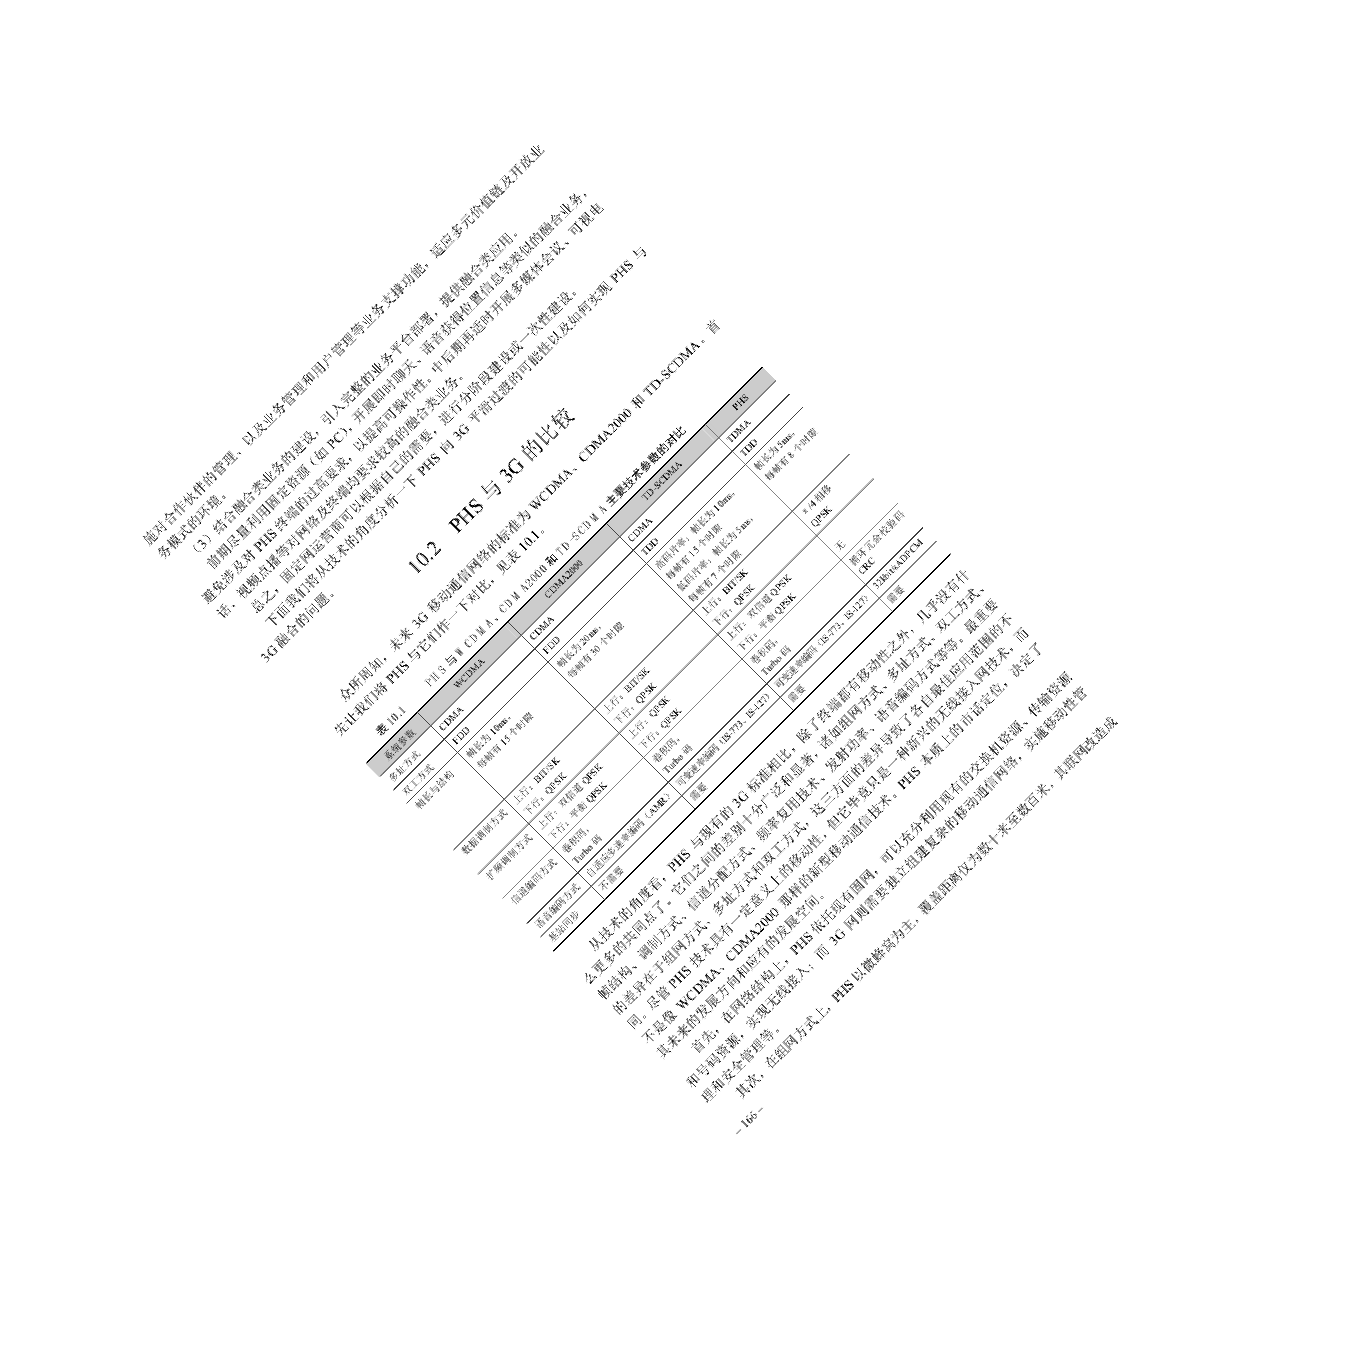

In [7]:
img = Image.open('/data/Hangyu_Folder/OCR_Project/data/text.bmp')
rotate(img, 45)

In [ ]:
from PIL import Image
import numpy as np
w = rotate_image_with_padding(image, 45)
result = Image.fromarray(w.astype(np.uint8))
result

In [ ]:
# original image
img = Image.open('/data/Hangyu_Folder/OCR_Project/data/text.bmp')

# converted to have an alpha layer
im2 = img.convert('RGBA')
# rotated image
rot = im2.rotate(22.2, expand=1)
# a white image same size as rotated image
fff = Image.new('RGBA', rot.size, (255,)*4)
# create a composite image using the alpha layer of rot as a mask
out = Image.composite(rot, fff, rot)
# save your work (converting back to mode='1' or whatever..)
out.convert(img.mode).save('test2.bmp')

In [ ]:
out